<a href="https://colab.research.google.com/github/ipavlopoulos/palit/blob/main/palit_clf_load%26explain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!gdown 1oCHi55WtUwaKEKHi_YyuEM_mzXaLFCVm
!gdown 1kNgqJCFZS4Q-P2YSaeaYp9P2bTobyOCV
!git clone https://github.com/ipavlopoulos/palit.git

In [2]:
from palit.classification import *
pll = pd.read_pickle("pll.csv")
dataset = pll.explode("img")
dataset = dataset[dataset.img.notna()]
print("Lines num:", dataset.shape[0])

w,h = 300,50
img_data = pd.DataFrame(dataset.img.apply(lambda x: x.shape).tolist(), index=dataset.index, columns=["H", "W"])
dataset = dataset[(img_data.W>w)&(img_data.H>h)]
dataset.insert(0, "lid", range(1, dataset.shape[0]+1))

pll_train, pll_test = train_test_split(dataset, test_size=0.1, random_state=2023)
pll_train, pll_val = train_test_split(pll_train, test_size=pll_test.shape[0], random_state=2023)
print(pll_train.shape[0], pll_val.shape[0], pll_test.shape[0])

Lines num: 4717
2218 278 278


In [3]:
net = CNNCLF(4) # 4 classes
net.load_state_dict(torch.load("checkpoint.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Acc: 0.73


<Figure size 640x480 with 0 Axes>

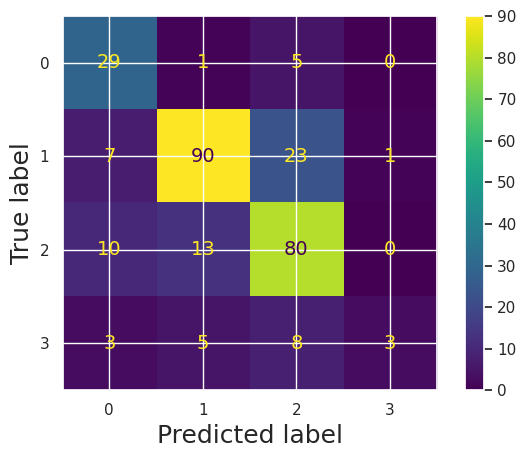

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

font = {'size'   : 14}
plt.rc('font', **font); plt.rcParams['axes.labelsize'] = 18; plt.rcParams['axes.titlesize'] = 18
plt.clf()

test_loader = DataLoader(ImageDataset(pll_test, transform=rs_transform), batch_size=1)
predictions, labels, loss, acc = validate_clf(net, test_loader)
print(f'Acc: {acc:.2f}')
ax = ConfusionMatrixDisplay.from_predictions(labels, predictions);
plt.tight_layout()
ax.figure_.savefig('confusion.pdf', format='PDF', dpi=300)

In [8]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.59      0.83      0.69        35
           1       0.83      0.74      0.78       121
           2       0.69      0.78      0.73       103
           3       0.75      0.16      0.26        19

    accuracy                           0.73       278
   macro avg       0.71      0.63      0.62       278
weighted avg       0.74      0.73      0.72       278



# Saliency

In [24]:
def saliency(model, inputs, labels, device='cpu'):
    inputs = inputs.to(device)
    labels = labels.to(device)
    inputs = inputs.requires_grad_(requires_grad=True)    
    outputs = model(inputs).to(device)
    loss = criterion(outputs, labels)
    loss.backward()  
    batch_grad = batch.grad.cpu().detach().numpy()
    batch_grad = np.squeeze(batch_grad)
    batch_grad = np.absolute(batch_grad)
    fig, axs = plt.subplots(2, 1, figsize=(10, 5))
    axs[0].imshow(batch_grad, cmap='hot', interpolation='nearest')
    axs[1].imshow(np.squeeze(batch.cpu().detach().numpy()), cmap='gray')
    return fig, axs, outputs.detach()

!rm -R heatmaps 
!mkdir heatmaps

dataloader = DataLoader(ImageDataset(pll_test, transform=rs_transform), batch_size=1, shuffle=False)
device = 'cpu'
criterion = nn.CrossEntropyLoss().to(device)
net.eval()
for batch_index, (batch, labels) in tqdm(enumerate(dataloader)):
  fig, axs, outputs = saliency(net, batch, labels)
  pred_date = np.argmax(outputs.cpu().detach(), 1).numpy()[0]+1
  plt.savefig(f"./heatmaps/heatmap_{batch_index:d}-DATE:{pll_test.iloc[batch_index].date}-PRED:{pred_date}")
  plt.close()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
%%capture
!zip heatmaps.zip heatmaps/*

# Ablation

mkdir: cannot create directory ‘ablations’: File exists


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


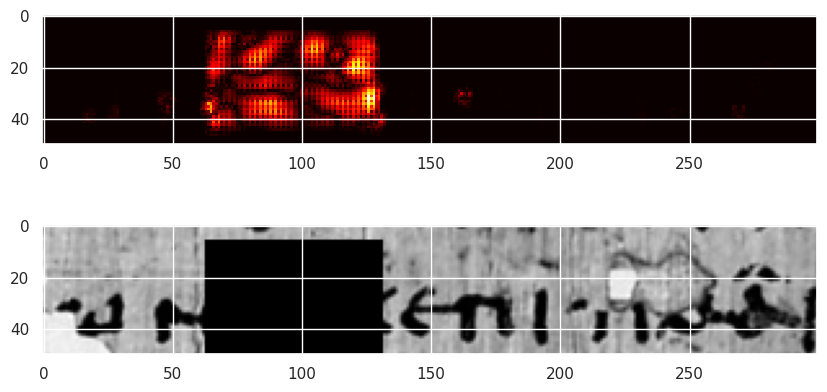

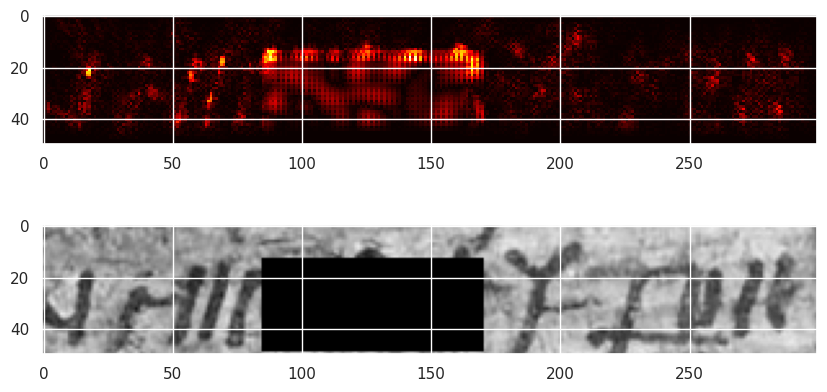

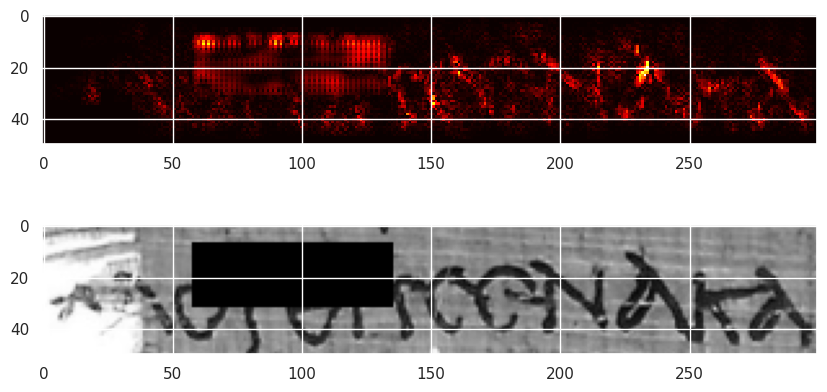

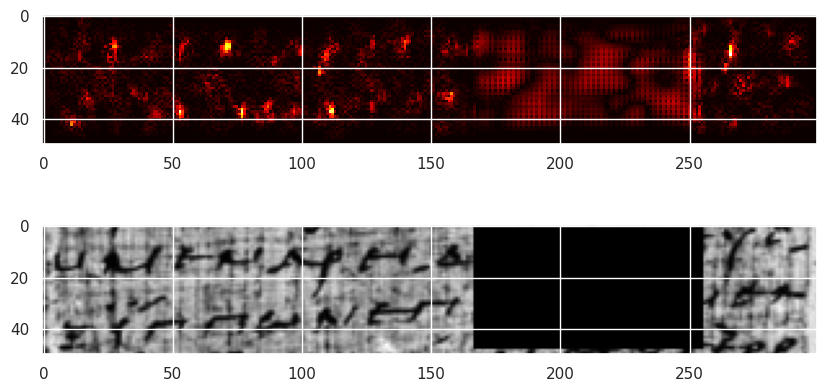

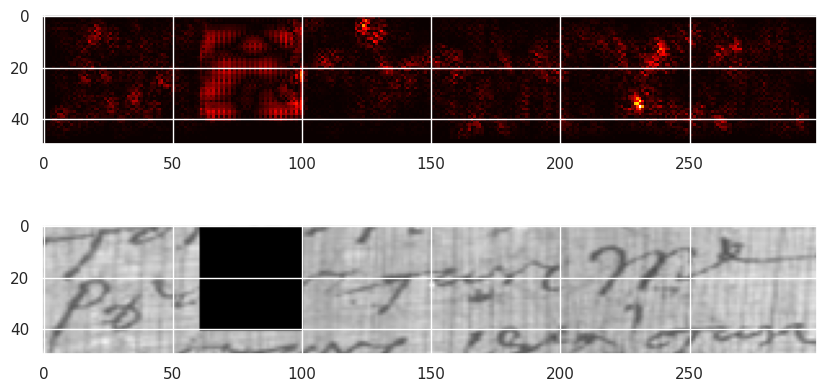

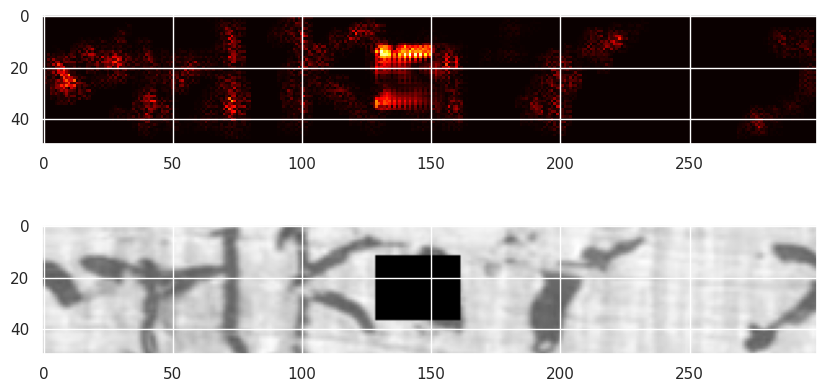

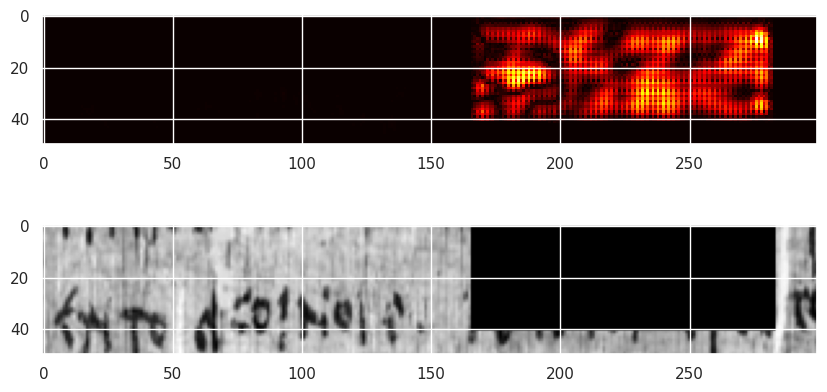

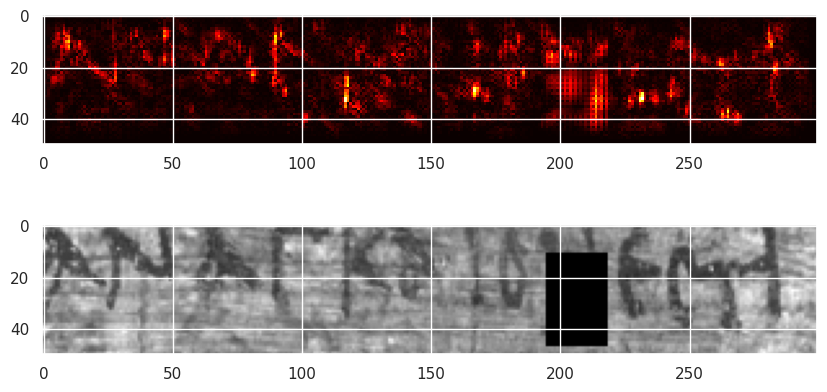

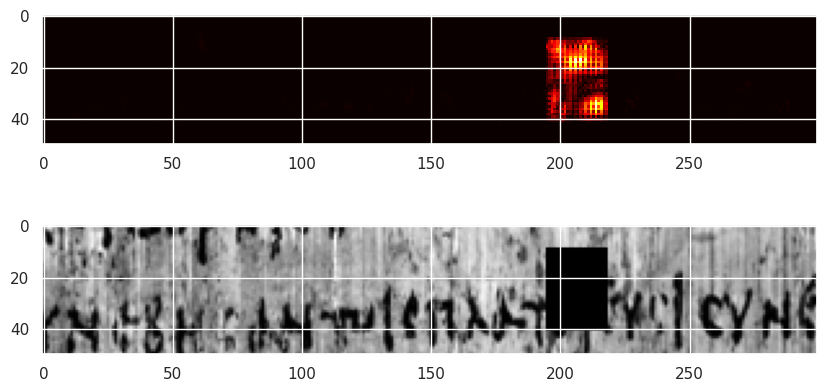

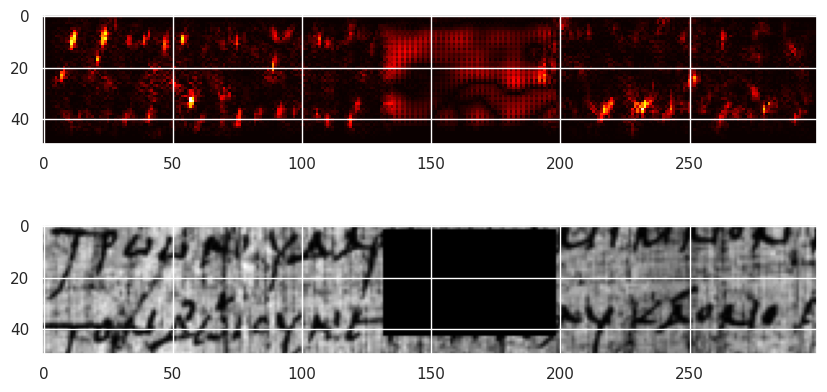

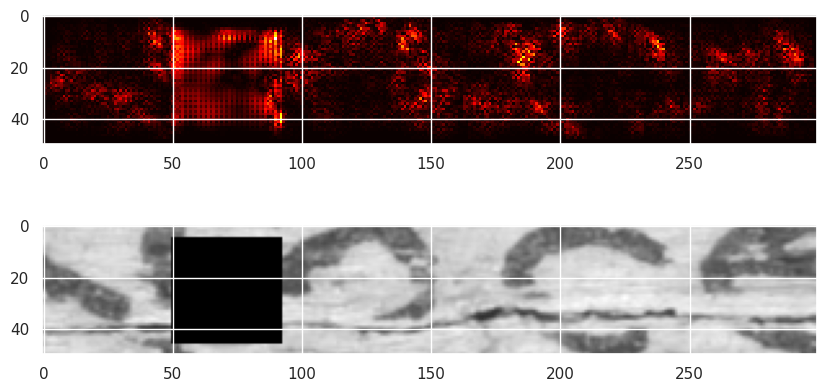

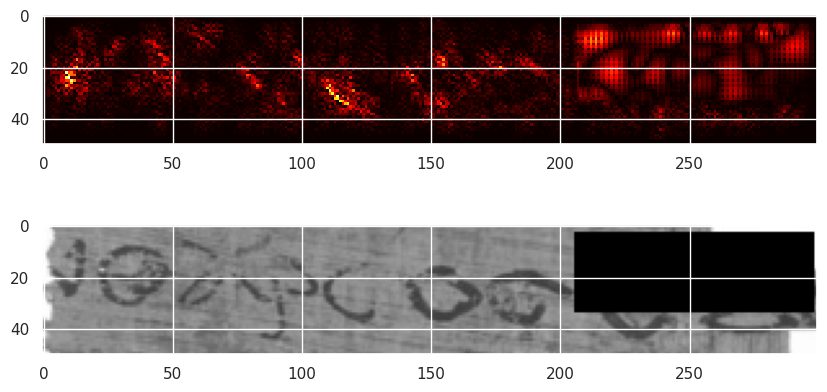

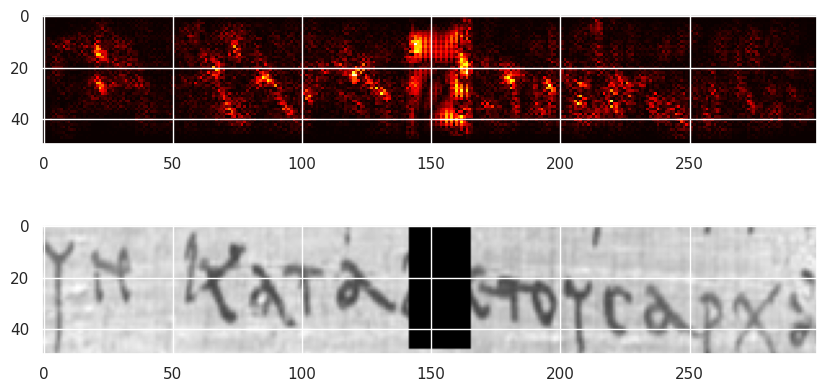

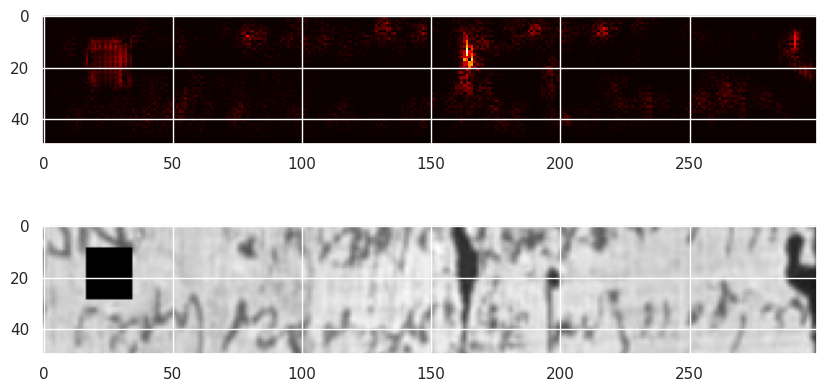

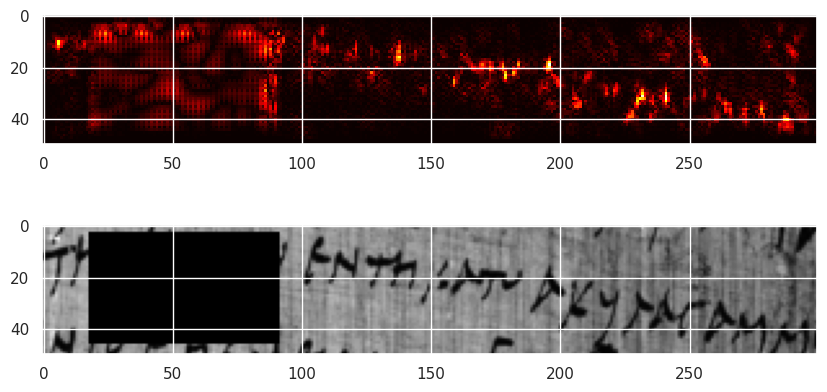

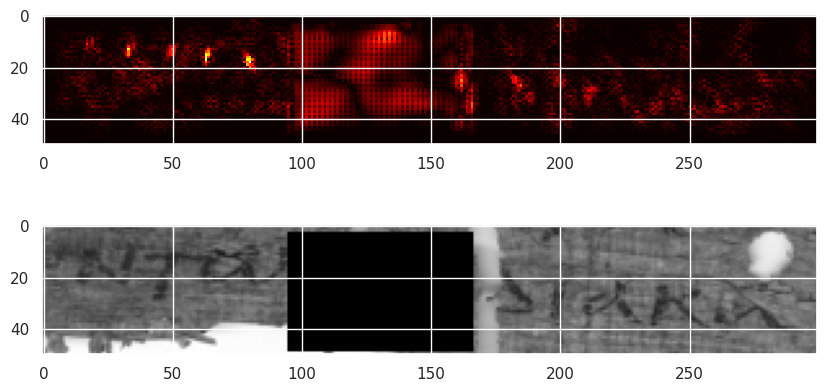

In [31]:
!mkdir ablations
batch_size = 16
dataloader = DataLoader(ImageDataset(pll_test.iloc[:batch_size], transform=white_fragment_ablation), batch_size=1)
device = 'cpu'
criterion = nn.CrossEntropyLoss().to(device)
net.eval()
for batch_index, (batch, labels) in enumerate(dataloader):
    batch = batch.to(device)
    labels = labels.to(device)
    batch = batch.requires_grad_(requires_grad=True)
    
    output = net(batch).to(device)
    loss = criterion(output, labels)

    loss.backward()
  
    batch_grad = batch.grad.cpu().detach().numpy()
    batch_grad = np.squeeze(batch_grad)
    batch_grad = np.absolute(batch_grad)

    fig, axs = plt.subplots(2, 1, figsize=(10, 5))
    axs[0].imshow(batch_grad, cmap='hot', interpolation='nearest')
    axs[1].imshow(np.squeeze(batch.cpu().detach().numpy()), cmap='gray')
    
    # saving the **black** box ablations
    plt.savefig(f"./ablations/bb_ablation_{batch_index:d}-DATE:{pll_test.iloc[batch_index].date}-PRED:{pred_date}")

    plt.show()
    plt.close()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


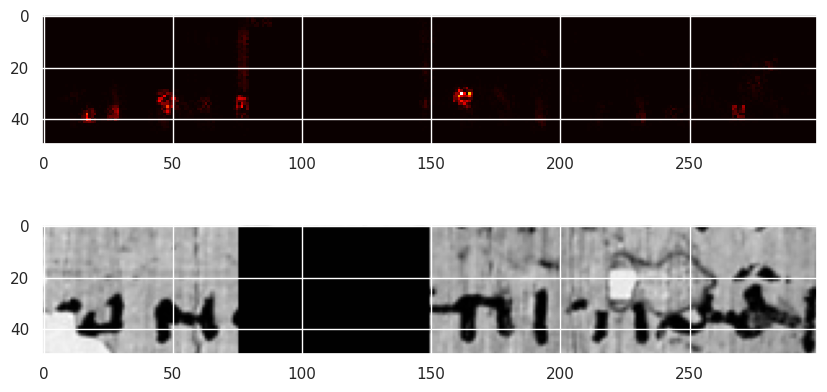

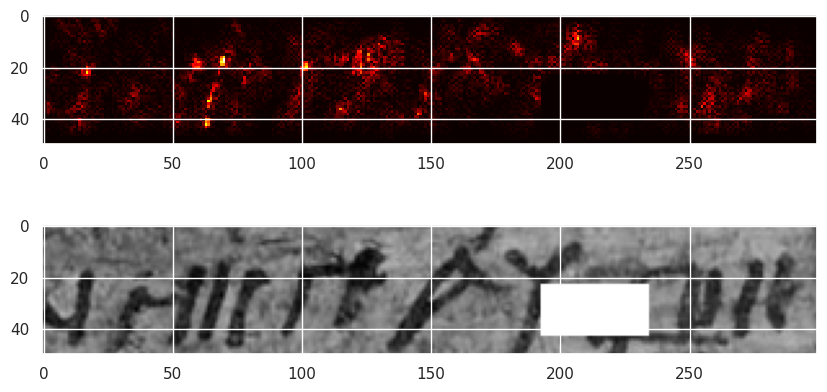

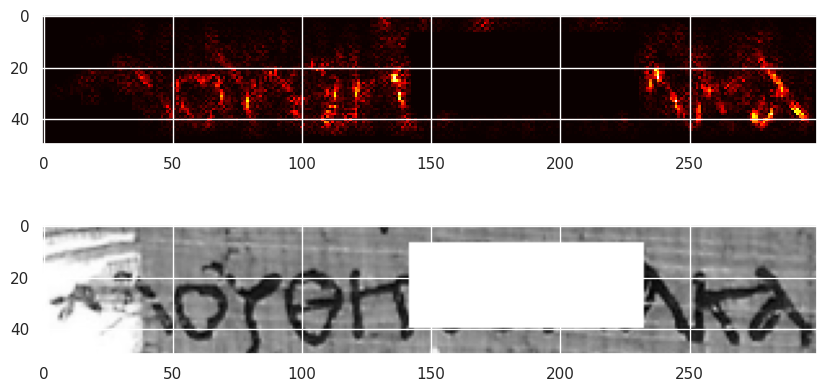

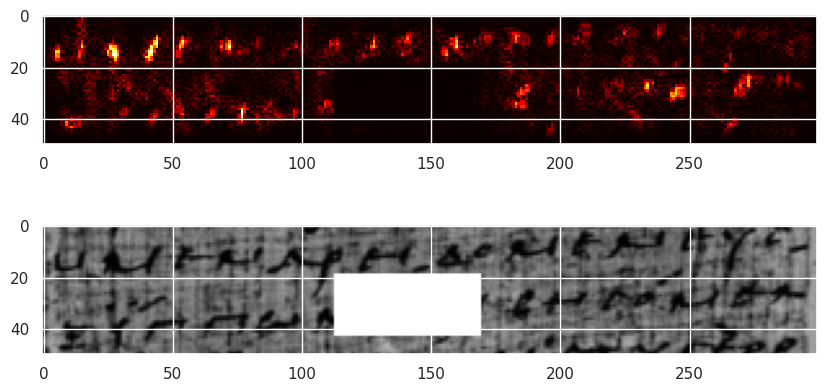

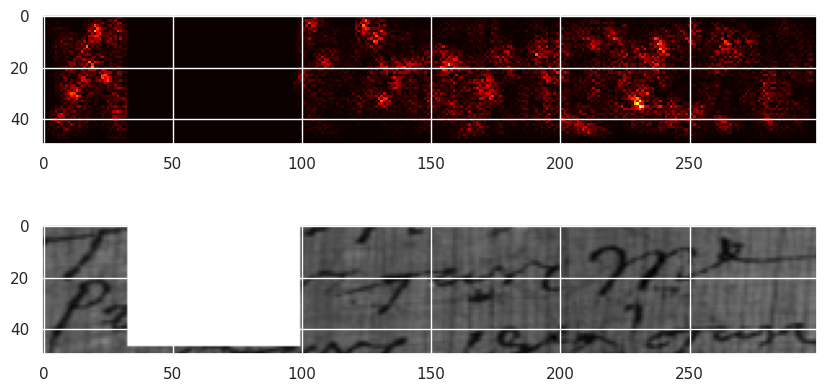

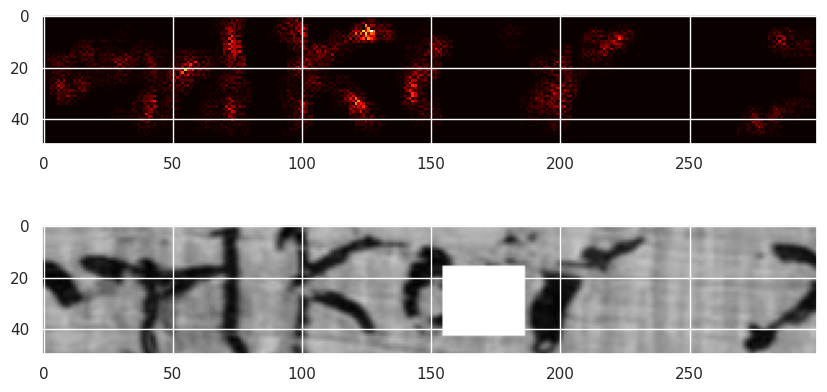

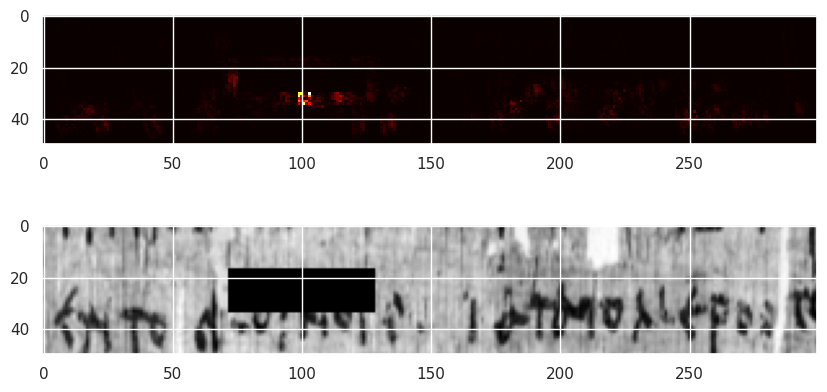

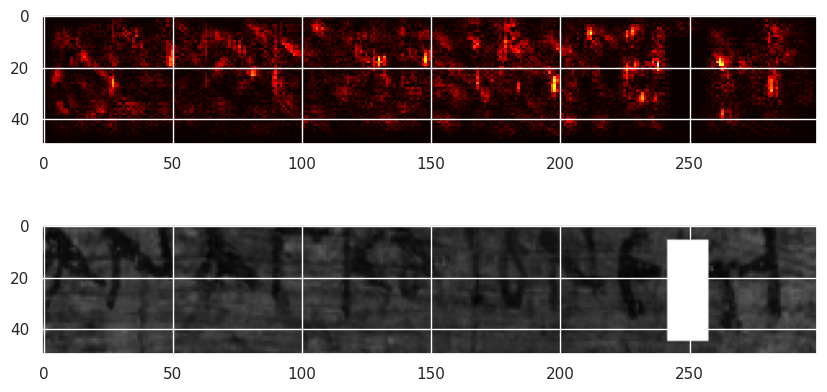

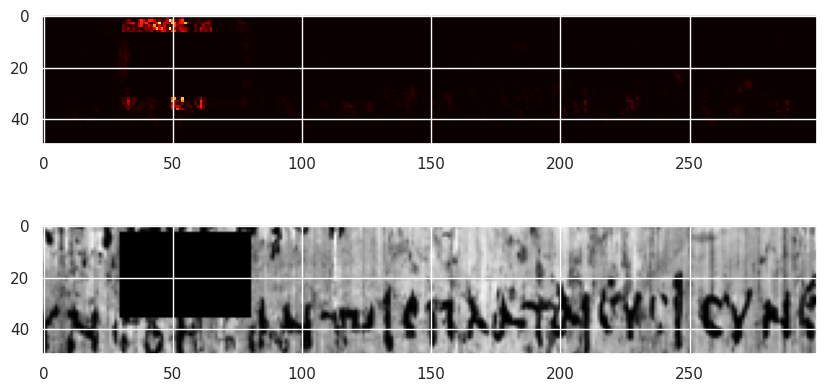

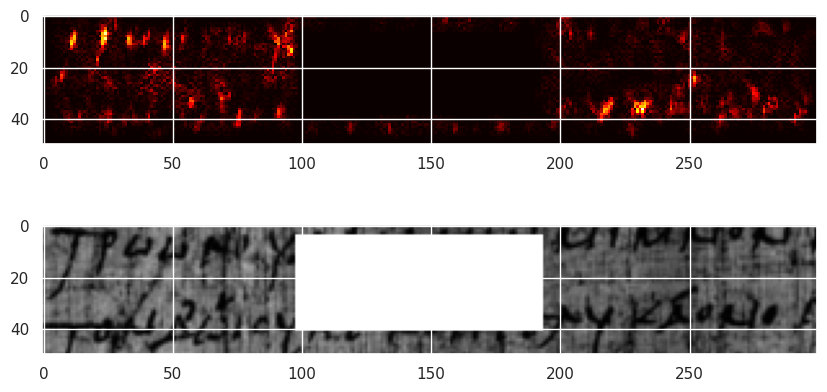

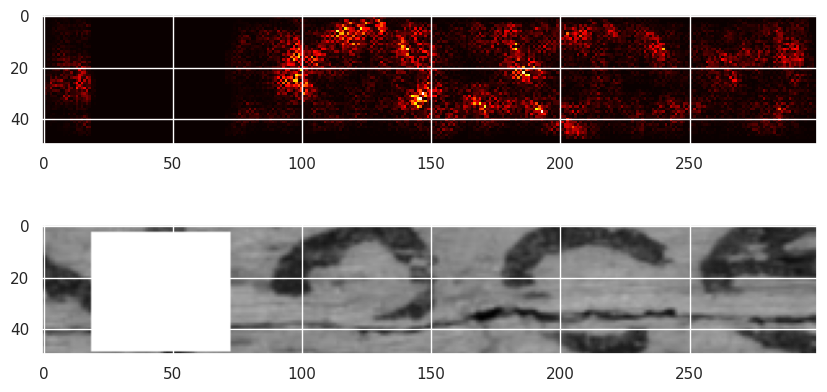

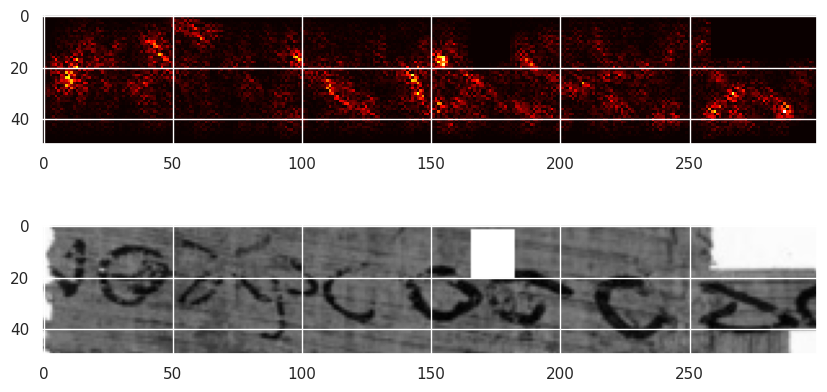

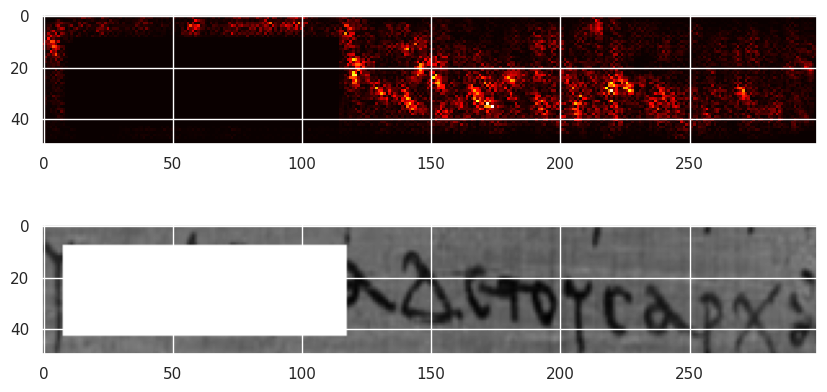

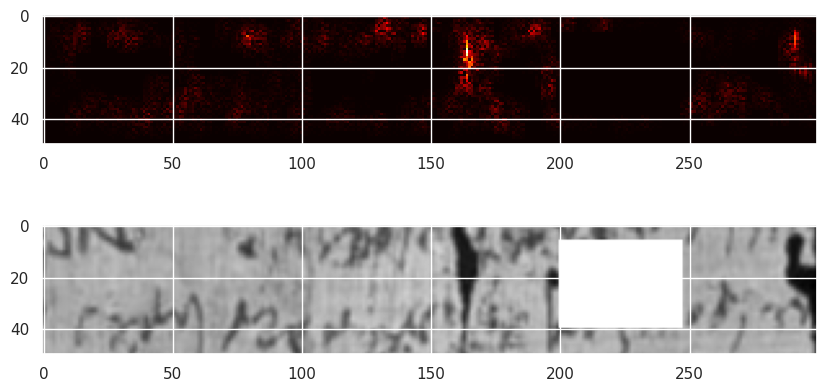

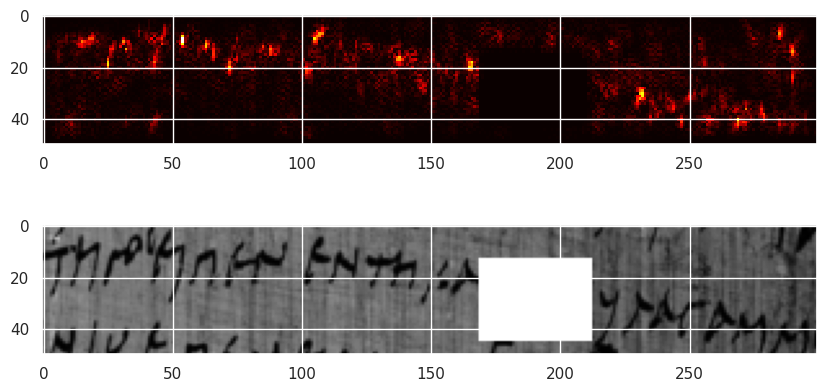

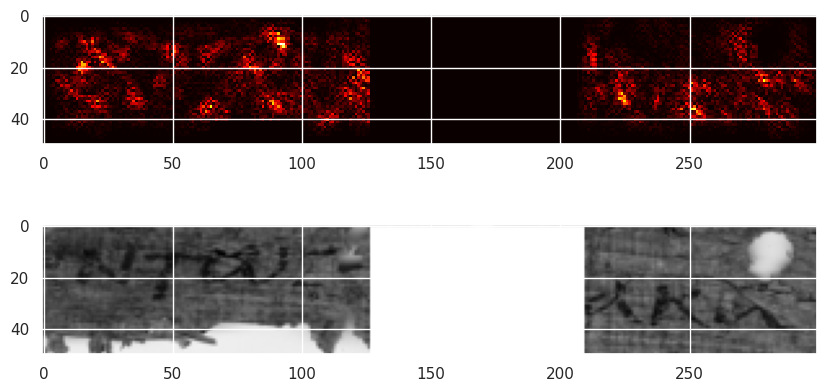

In [32]:
batch_size = 16
dataloader = DataLoader(ImageDataset(pll_test.iloc[:batch_size], transform=black_fragment_ablation), batch_size=1)
device = 'cpu'
criterion = nn.CrossEntropyLoss().to(device)
net.eval()
for batch_index, (batch, labels) in enumerate(dataloader):
    batch = batch.to(device)
    labels = labels.to(device)
    batch = batch.requires_grad_(requires_grad=True)
    
    output = net(batch).to(device)
    loss = criterion(output, labels)

    loss.backward()
  
    batch_grad = batch.grad.cpu().detach().numpy()
    batch_grad = np.squeeze(batch_grad)
    batch_grad = np.absolute(batch_grad)

    fig, axs = plt.subplots(2, 1, figsize=(10, 5))
    axs[0].imshow(batch_grad, cmap='hot', interpolation='nearest')
    axs[1].imshow(np.squeeze(batch.cpu().detach().numpy()), cmap='gray')

    # saving the **white** box ablations
    plt.savefig(f"./ablations/wb_ablation_{batch_index:d}-DATE:{pll_test.iloc[batch_index].date}-PRED:{pred_date}")

    plt.show()
    plt.close()

In [ ]:
%%capture
!zip ablations.zip ablations/*